In [70]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [71]:
df = pd.read_csv('./csv/data/_fixed_train_data.csv')
df = df.drop(['screen_height', 'screen_width'], axis=1)

In [72]:
df_test = pd.read_csv('./csv/data/_fixed_train_data.csv')
df_test = df_test.drop(['screen_height', 'screen_width'], axis=1)

In [73]:
df.shape

(15, 6)

In [74]:
df.head()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
0,713.406067,382.448242,576.005981,372.060638,50,738
1,709.982239,380.854797,574.124084,370.919800,50,738
2,706.978210,378.248840,571.279175,369.640076,50,738
3,697.825378,373.718597,563.162903,366.610474,50,738
4,688.999634,370.481934,555.069763,364.334473,50,738


In [75]:
df.describe()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,684.265983,367.405735,548.828121,362.533893,720.000000,394.000000
std,15.891807,7.649658,15.766244,4.952132,566.253351,290.733064
min,667.526611,361.018280,531.639587,357.955627,50.000000,50.000000
25%,669.840271,362.248199,533.896545,358.584167,50.000000,50.000000
50%,680.911743,362.848175,546.262268,360.619080,720.000000,394.000000
75%,693.412506,372.100266,559.116333,365.472473,1390.000000,738.000000
max,713.406067,382.448242,576.005981,372.060638,1390.000000,738.000000


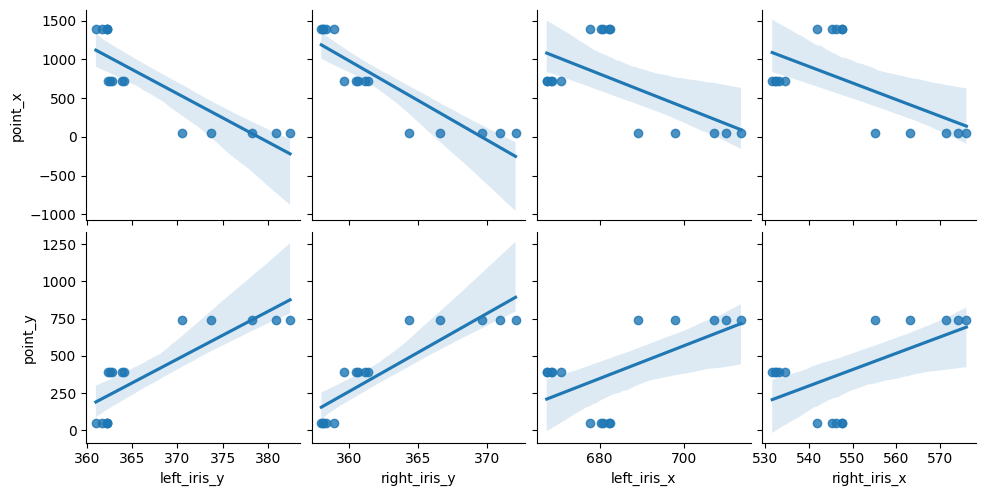

In [76]:
sns.pairplot(df, x_vars=['left_iris_y', 'right_iris_y', 'left_iris_x',
             'right_iris_x'], y_vars=['point_x', 'point_y'], kind='reg')
plt.show()

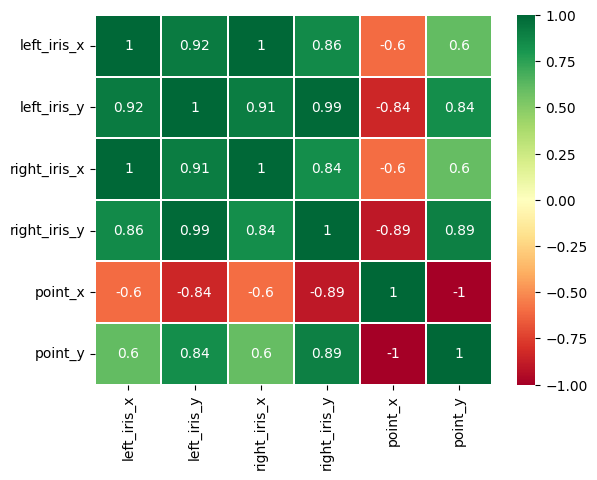

In [77]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

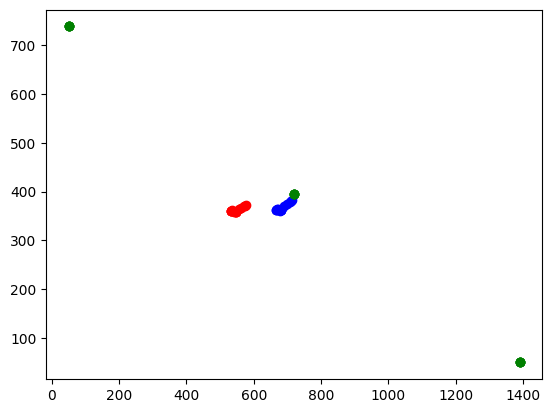

In [78]:
#plot eyes point
plt.scatter(df['left_iris_x'], df['left_iris_y'], color='blue')
plt.scatter(df['right_iris_x'], df['right_iris_y'], color='red')
plt.scatter(df['point_x'], df['point_y'], color='green')
plt.show()

In [79]:
X_train_x = df[['left_iris_x', 'right_iris_x']]
y_train_x = df['point_x']

In [80]:
sc = StandardScaler()
X_train_x = sc.fit_transform(X_train_x)

In [81]:
X_train_x[:5]

array([[1.89801278, 1.78430313],
       [1.67500486, 1.6607513 ],
       [1.47934021, 1.47397496],
       [0.88317885, 0.94111883],
       [0.30832202, 0.4097814 ]])

In [82]:
y_train_x[:5]

0    50
1    50
2    50
3    50
4    50
Name: point_x, dtype: int64

In [83]:
X_test_x = df_test[['left_iris_x', 'right_iris_x']]
y_test_x = df_test['point_x']

In [84]:
sc = StandardScaler()
X_test_x = sc.fit_transform(X_test_x)

In [85]:
model_x = make_pipeline(PolynomialFeatures(2), linear_model.LinearRegression())
model_x.fit(X_train_x, y_train_x)
y_pred_x = model_x.predict(X_test_x)
r2_score(y_test_x, y_pred_x)

0.9502720165361552

In [86]:
y_pred_x

array([  80.43413002, -139.78973472,  161.42427965,  203.95317435,
         83.62711798,  898.34911115,  813.63124394,  602.61975406,
        566.5263435 ,  772.75310198, 1489.21024756, 1481.56072941,
       1253.710242  , 1246.13234658, 1285.85791253])

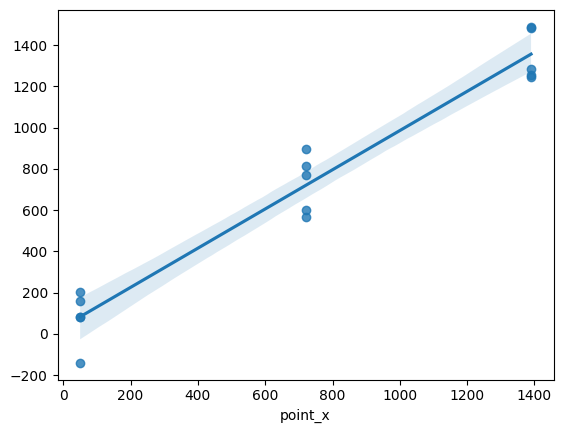

In [87]:
sns.regplot(x=y_test_x, y=y_pred_x)
plt.show()

In [88]:
X_train_y = df[['left_iris_y', 'right_iris_y']]
y_train_y = df['point_y']

In [89]:
sc = StandardScaler()
X_train_y = sc.fit_transform(X_train_y)

In [90]:
X_train_y[:5]

array([[2.03544708, 1.99128746],
       [1.81983325, 1.75282852],
       [1.46721332, 1.48533963],
       [0.85421246, 0.85208996],
       [0.41624969, 0.37635854]])

In [91]:
y_train_y[:5]

0    738
1    738
2    738
3    738
4    738
Name: point_y, dtype: int64

In [92]:
X_test_y = df_test[['left_iris_y', 'right_iris_y']]
y_test_y = df_test['point_y']

In [93]:
sc = StandardScaler()
X_test_y = sc.fit_transform(X_test_y)

In [94]:
model = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression())
model.fit(X_train_y, y_train_y)
y_pred_y = model.predict(X_test_y)
r2_score(y_test_y, y_pred_y)

0.9630393377798092

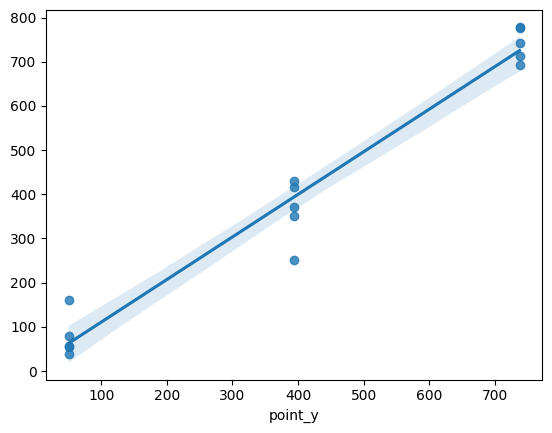

In [95]:
sns.regplot(x=y_test_y, y=y_pred_y)
plt.show()

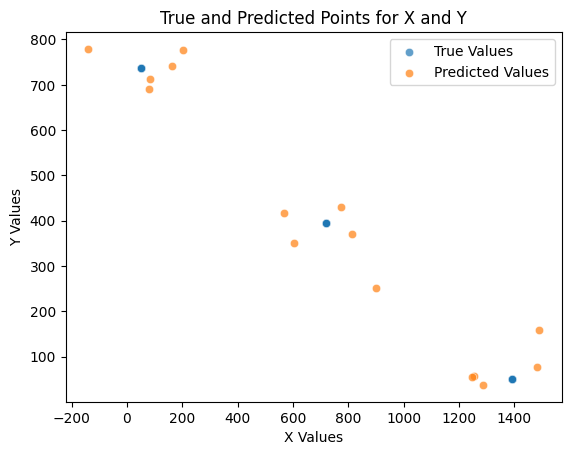

In [96]:
data = {'True X': y_test_x, 'Predicted X': y_pred_x,
        'True Y': y_test_y, 'Predicted Y': y_pred_y}

sns.scatterplot(x='True X', y='True Y', data=data,
                label='True Values', alpha=0.7)
sns.scatterplot(x='Predicted X', y='Predicted Y', data=data,
                label='Predicted Values', alpha=0.7)

plt.title('True and Predicted Points for X and Y')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.legend()

plt.show()

In [97]:
df_data = pd.DataFrame(data)
df_data['True XY'] = list(zip(df_data['True X'], df_data['True Y']))

In [98]:
df_data.head()

,True X,Predicted X,True Y,Predicted Y,True XY
0,50,80.434130,738,691.611750,"(50, 738)"
1,50,-139.789735,738,779.160708,"(50, 738)"
2,50,161.424280,738,742.013859,"(50, 738)"
3,50,203.953174,738,776.662459,"(50, 738)"
4,50,83.627118,738,711.931083,"(50, 738)"


In [99]:
df_data.shape

(15, 5)

In [100]:
df_data = df_data[(df_data['Predicted X'] >= 0) &
                  (df_data['Predicted Y'] >= 0)]
df_data = df_data[(abs(df_data['Predicted X'] - df_data['True X']) <= 100)
                  & (abs(df_data['Predicted Y'] - df_data['True Y']) <= 100)]

In [101]:
df_data.shape

(5, 5)

In [102]:
# Precision is calculated via the Root Mean Square from the
# successive data points [in degrees of visual angle θi between
# successive (x1,y1) to (xi+1, yi+1) samples], both for each eye
# individually and as a mean from the two

# Another option to describe the variation in the data is to
# measure the standard deviation of the data set, equivalent
# to the RMS normalized by the mean

def func_x(group): return np.sqrt(
    np.sum(np.square([group['Predicted X'], group['True X']])))


def func_y(group): return np.sqrt(
    np.sum(np.square([group['Predicted Y'], group['True Y']])))


precision_x = df_data.groupby('True XY').apply(func_x)
precision_y = df_data.groupby('True XY').apply(func_y)

precision_xy = (precision_x + precision_y) / 2
precision_xy = precision_xy / np.mean(precision_xy)
print('mean', precision_xy)

mean True XY
(50, 738)     0.786588
(720, 394)    1.153197
(1390, 50)    1.060215
dtype: float64


In [103]:
data = {}

for index, row in df_data.iterrows():

    outer_key = str(row['True X'])
    inner_key = str(row['True Y'])

    if outer_key not in data:
        data[outer_key] = {}

    data[outer_key][inner_key] = {
        'predicted_x': df_data[(df_data['True X'] == row['True X']) & (df_data['True Y'] == row['True Y'])]['Predicted X'].values.tolist(),
        'predicted_y': df_data[(df_data['True X'] == row['True X']) & (df_data['True Y'] == row['True Y'])]['Predicted Y'].values.tolist(),
        'PrecisionSD': precision_xy[(row['True X'], row['True Y'])]
    }

In [104]:
data = np.array([y_pred_x, y_pred_y]).T

In [105]:
data.shape

(15, 2)

In [106]:
model = KMeans(n_clusters=5, n_init='auto', init='k-means++')
y_kmeans = model.fit_predict(data)

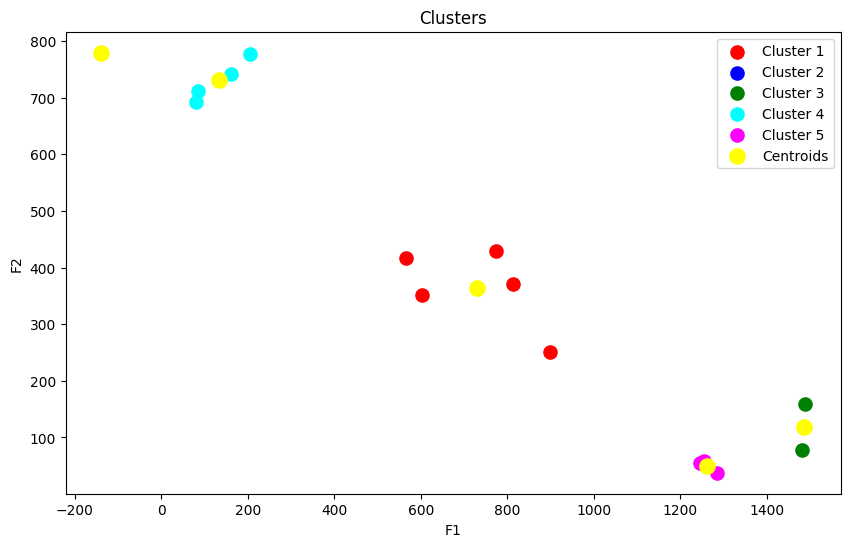

In [107]:
plt.figure(figsize=(10, 6))

plt.scatter(data[y_kmeans == 0, 0], data[y_kmeans == 0, 1],
            s=90, c='red', label='Cluster 1')
plt.scatter(data[y_kmeans == 1, 0], data[y_kmeans == 1, 1],
            s=90, c='blue', label='Cluster 2')
plt.scatter(data[y_kmeans == 2, 0], data[y_kmeans == 2, 1],
            s=90, c='green', label='Cluster 3')
plt.scatter(data[y_kmeans == 3, 0], data[y_kmeans == 3, 1],
            s=90, c='cyan', label='Cluster 4')
plt.scatter(data[y_kmeans == 4, 0], data[y_kmeans == 4, 1],
            s=90, c='magenta', label='Cluster 5')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[
            :, 1], s=120, c='yellow', label='Centroids')

plt.title('Clusters')

plt.xlabel('F1')
plt.ylabel('F2')

plt.legend()

plt.show()

### -------- teste --------

In [108]:
def plot(ax, y_test_x, y_pred_x, y_test_y, y_pred_y, title=None):

    y_test_x = np.array(y_test_x)
    y_test_y = np.array(y_test_y)

    true_points = [(y_test_x[i], y_test_y[i]) for i in range(len(y_test_x))]

    error_range = 0.05

    data = {'True X': y_test_x, 'Predicted X': y_pred_x,
            'True Y': y_test_y, 'Predicted Y': y_pred_y}

    sns.scatterplot(x='True X', y='True Y', data=data,
                    label='True Values', alpha=0.7, ax=ax, color='red')
    sns.scatterplot(x='Predicted X', y='Predicted Y', data=data,
                    label='Predicted Values', alpha=0.7, ax=ax, color='green')

    circle_radius = error_range * (max(y_test_x) - min(y_test_x)
                                   + max(y_test_y) - min(y_test_y)) / 2

    for true_x, true_y in true_points:

        x_within_range = [y_pred_x[j] for j in range(len(y_test_x)) if abs(
            y_test_x[j] - true_x) <= error_range]
        y_within_range = [y_pred_y[j] for j in range(len(y_test_y)) if abs(
            y_test_y[j] - true_y) <= error_range]

        if len(x_within_range) > 1 and len(y_within_range) > 1:

            combined_predictions = x_within_range + y_within_range
            combined_true = [true_x] * len(x_within_range) + \
                [true_y] * len(y_within_range)
            #true_values = [true_x] * len(x_within_range) + \
            #    [true_y] * len(y_within_range)

            r2_combined = r2_score(combined_true, combined_predictions)
            mae_combined = mean_absolute_error(
                combined_true, combined_predictions)

            circle = plt.Circle((true_x, true_y), circle_radius,
                                color='yellow', fill=False)
            ax.add_patch(circle)

            ax.text(true_x + 0.1, true_y + 0.1, f'R2={r2_combined:.2f}\nMAE={mae_combined:.2f}',
                    fontsize=8, color='blue')

    title = title if title else 'True and Predicted Points for X and Y'
    ax.set_title(title)
    ax.legend()

In [109]:
def analysis(df, ax=None, title=None):

    # x
    X_x = df[['left_iris_x', 'right_iris_x']]
    X_y = df['point_x']

    sc = StandardScaler()
    X_x = sc.fit_transform(X_x)

    X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
        X_x, X_y, test_size=0.2, random_state=42)

    model = linear_model.LinearRegression()
    model.fit(X_train_x, y_train_x)
    y_pred_x = model.predict(X_test_x)
    r2_score(y_test_x, y_pred_x)

    # y
    X_y = df[['left_iris_y', 'right_iris_y']]
    y_y = df['point_y']

    sc = StandardScaler()
    X_y = sc.fit_transform(X_y)

    X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(
        X_y, y_y, test_size=0.2, random_state=42)

    model = linear_model.LinearRegression()
    model.fit(X_train_y, y_train_y)
    y_pred_y = model.predict(X_test_y)
    r2_score(y_test_y, y_pred_y)

    plot(ax, y_test_x, y_pred_x, y_test_y, y_pred_y, title)

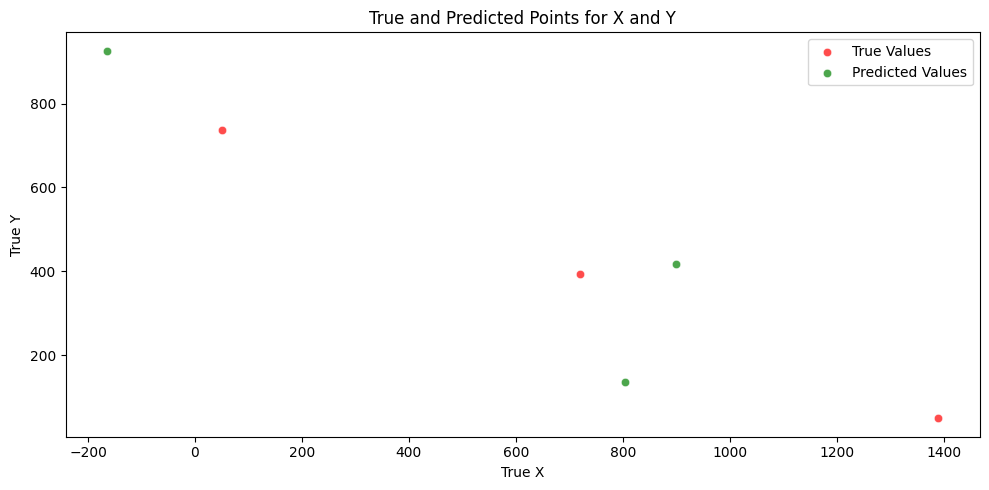

In [110]:
df = pd.read_csv('./csv/data/_fixed_train_data.csv')
df = df.drop(['screen_height', 'screen_width'], axis=1)

df_list = [df]

# num_rows = len(df_list) // 2 + len(df_list) % 2
# num_cols = min(2, len(df_list))

num_rows = len(df_list)
num_cols = 1

fig_height = 5 * num_rows
fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(10, fig_height), squeeze=False)

for i, df in enumerate(df_list):

    # row_idx = i // num_cols
    # col_idx = i % num_cols

    row_idx = i
    col_idx = 0

    ax = axes[row_idx, col_idx]
    analysis(df, ax)

plt.tight_layout()
plt.show()